In [1]:
exported_animelist = 'animelist_1708066880_-_14171317.xml'
selected_genres = ['Comedy', 'Slice of Life'] # or [''] to select all genres
types_anime = ['TV', 'Movie']
min_year = 1930
max_year = 9999
quartile1 = 0.3 # In case of a "Memory error", increase
quartile3 = 0.6 # In case of a "Memory error", reduce

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import xml.etree.ElementTree as ET
%matplotlib inline

In [3]:
data_train = pd.read_csv('data/rating_complete.csv')
print(len(data_train))
data_train.head(2)

57633278


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [4]:
anime = pd.read_csv('data/anime.csv')
anime = anime.rename(columns={"MAL_ID": "anime_id"})
anime3 = anime[['anime_id', 'Score', 'Popularity']].copy()
anime.head(2)

,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


Creating datafraime from the exported animelist

In [5]:
root = ET.parse(exported_animelist).getroot()
anime_id = []
rating = []
for i, j in zip(root.findall('anime/series_animedb_id'), root.findall('anime/my_score')):
    if int(j.text) != 0:
        anime_id.append(int(i.text))
        rating.append(float(j.text))

my_animelist = pd.DataFrame({'user_id': 400000, 'anime_id': anime_id, 'rating': rating})

Creating genres table

In [6]:
genres = []

for i in range(len(anime)):
    genres.extend(anime.iloc[i]['Genres'].split(', '))

colms = list(set(genres))

df_genres = pd.DataFrame(columns=colms)
df_genres['anime_id'] = anime['anime_id']
df_genres = df_genres.fillna(0)
df_genres.index = df_genres['anime_id']
df_genres.drop('anime_id', axis=1, inplace=True)

for i in anime['anime_id'].values:
    list_genres = anime.loc[anime['anime_id'] == i]['Genres'].values[0].split(', ')
    for j in list_genres:
        df_genres.at[i, j] = 1

sum_col = [sum(df_genres[i]) for i in df_genres.columns]

for i in df_genres.columns:
    if sum(df_genres[i]) < np.percentile(np.array(sum_col), 10):
        try:
            df_genres.drop(i, axis=1, inplace=True)
        except KeyError:
            pass

df_genres.head(3)

,Mecha,Shounen Ai,Slice of Life,Magic,Thriller,Romance,Super Power,Action,Game,Sports,...,Shoujo,Comedy,Military,Supernatural,Hentai,Cars,Shounen,Psychological,Adventure,Demons
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0


Limit by genres

In [7]:
if selected_genres[0] != '':
    my_genres = []
    for i in selected_genres:
        my_genres.extend(list(df_genres.loc[df_genres[i] == 1].index))
    counter_genres = Counter(my_genres)
    max_val = max(counter_genres.values())
    my_genres = list(filter(lambda x:  counter_genres[x] == max_val, counter_genres.keys()))
    data_train = data_train.loc[data_train['anime_id'].isin(my_genres)]
    my_animelist = my_animelist.loc[my_animelist['anime_id'].isin(my_genres)]
    anime3 = anime3.loc[anime3['anime_id'].isin(my_genres)]
    print(len(data_train))

6176162


Limit by years

In [8]:
anime_id = []
year = []

for i in anime['anime_id']:
    anime_id.append(i)
    try:
        year.append(int(re.findall('[0-9]{4}', str(anime.loc[anime['anime_id'] == i]['Aired'].values[0]))[0]))
    except IndexError:
        year.append(8888)

df_year = pd.DataFrame({'anime_id': anime_id, 'year': year})
df_year = df_year.loc[(df_year['year'] < max_year)&(df_year['year'] > min_year)]

data_train = data_train.loc[data_train['anime_id'].isin(df_year['anime_id'])]
my_animelist = my_animelist.loc[my_animelist['anime_id'].isin(df_year['anime_id'])]
anime3 = anime3.loc[anime3['anime_id'].isin(df_year['anime_id'])]
len(data_train)

6176162

Limit by types

In [9]:
if types_anime[0] != '':
    my_types = []
    for i in types_anime:
        my_types.extend(anime.loc[anime['Type'] == i]['anime_id'].values.tolist())
    anime3 = anime3.loc[anime3['anime_id'].isin(my_types)]
    data_train = data_train.loc[data_train['anime_id'].isin(my_types)]
    print(len(data_train))

5233881


### Reducing amount of data

In [10]:
popularity_anime = data_train.groupby('anime_id')['rating'].count().reset_index().sort_values('rating', ascending=False)
popularity_anime['rating_rank'] = popularity_anime['rating'].rank()
popularity_anime.drop('rating', axis=1, inplace=True)
popularity_anime.head(3)

,anime_id,rating_rank
110,4224,575.0
76,2167,574.0
244,14813,573.0


In [11]:
data_train = pd.merge(data_train, popularity_anime, how='left', on='anime_id')

In [12]:
user_sum_rating = data_train.groupby('user_id')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_sum_rating.head(3)

,user_id,rating_rank
0,189037,162951.0
1,68042,158390.0
2,283786,157739.5


In [13]:
user_count_rating = data_train.groupby('user_id')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_count_rating.head(3)

,user_id,rating_rank
0,189037,558
1,68042,533
2,162615,515


In [14]:
user_rating = pd.merge(user_sum_rating, user_count_rating, how='left', on='user_id')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,292.026882
1,68042,297.166979
2,283786,331.385504


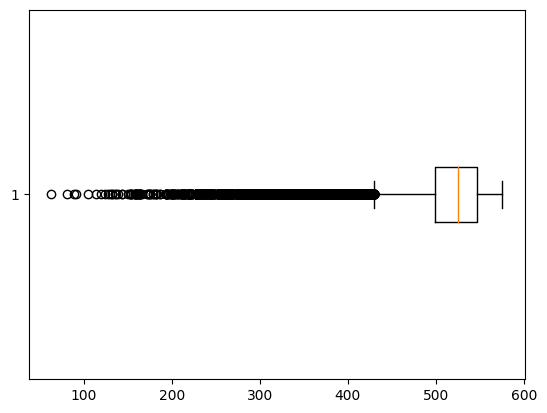

In [15]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

Selected interquartile range 

Q1=505.92083926031296, Q3=533.5714285714286


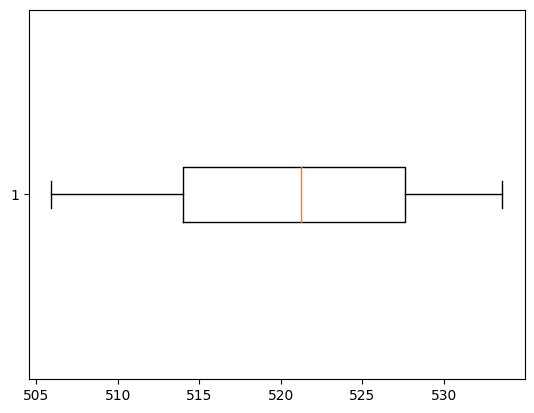

In [16]:
Q1 = user_rating['rating_rank'].quantile(quartile1)
Q3 = user_rating['rating_rank'].quantile(quartile3)
print(f'Q1={Q1}, Q3={Q3}')
user_rating_iqr = user_rating.loc[(user_rating['rating_rank'] < Q3) & (user_rating['rating_rank'] > Q1)]
user_list = user_rating_iqr['user_id'].tolist()
plt.boxplot(user_rating_iqr['rating_rank'], vert=False)
plt.show()

In [17]:
data_train = data_train.loc[data_train['user_id'].isin(user_list)]
# data_train.drop('rating_rank', axis=1, inplace=True)
data_train = pd.concat([data_train, my_animelist], ignore_index=True)
len(data_train)

1649340

In [18]:
import implicit
from scipy.sparse import csr_matrix

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=100,
                                        regularization=0.05, 
                                        alpha=2.0,
                                        iterations=20,
                                        random_state=38)

# train the model on a sparse matrix of user/item/confidence weights
user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='anime_id',
                                  values='rating',
                                  fill_value=0)

# scipy resets indexes
idALS_anime_id = dict((i, j) for i, j in enumerate(user_item_matrix.columns))

user_item_matrix = user_item_matrix.astype(float)
user_item_matrix_csr = csr_matrix(user_item_matrix).tocsr()

model.fit(user_item_matrix_csr)

C:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Python311\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.50s/it]


In [19]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
#user_item_matrix_csr = bm25_weight(user_item_matrix_csr, K1=100, B=0.8)

In [20]:
id_score = model.recommend(-1, user_item_matrix_csr[-1], N=250, filter_already_liked_items=True)
anime_id = [idALS_anime_id[i] for i in id_score[0]]
ALScore = dict((i, j) for i, j in zip(anime_id, id_score[1]))

In [21]:
my_animelist = my_animelist.loc[my_animelist['rating'] > 6]
my_genres = df_genres[df_genres.index.isin(my_animelist['anime_id'])].mean().values

def rec_final(rec):
    name = []
    date = []
    url = []
    als_score = []
    score_mal = []
    corr = []

    for i in rec:
        if i not in set(my_animelist['anime_id']):
            name.append(anime.loc[anime['anime_id'] == i]['Name'].values[0])
            date.append(anime.loc[anime['anime_id'] == i]['Aired'].values[0])
            url.append('https://myanimelist.net/anime/' + str(i))
            if type(rec) == list:
                als_score.append(ALScore[i])
            score_mal.append(anime.loc[anime['anime_id'] == i]['Score'].values[0])
            corr.append(0)
            if df_genres.loc[int(i)].sum() != 0:
                corr[-1] = (np.corrcoef(my_genres, df_genres.loc[int(i)])[0, 1])

    df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'score mal': score_mal, 'correlation': corr})
    df['rank'] = df['score mal'].rank() + df['correlation'].rank()
    df = df.sort_values('rank', ascending=False)
    if type(rec) == list:
        df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'ALS score': als_score, 'score mal': score_mal, 'correlation': corr})
        df['rank'] = df['score mal'].rank() + df['ALS score'].rank() + df['correlation'].rank()
        df = df.sort_values('rank', ascending=False)
    return df

In [22]:
rec_final(anime_id).to_html(f'{" ".join(map((str), selected_genres))} {" ".join(map((str), types_anime))} ALS recommendations {min_year} - {max_year}.html', encoding='utf-8', index=False, render_links=True)
rec_final(anime_id)[:10]

,name,date,url,ALS score,score mal,correlation,rank
4,Minami-ke Tadaima,"Jan 6, 2013 to Mar 31, 2013",https://myanimelist.net/anime/14511,0.811060,7.69,0.937880,685.5
31,Jungle wa Itsumo Hare nochi Guu,"Apr 3, 2001 to Sep 25, 2001",https://myanimelist.net/anime/253,0.467690,7.84,0.937880,669.5
46,Kuragehime,"Oct 15, 2010 to Dec 31, 2010",https://myanimelist.net/anime/8129,0.350606,8.13,0.921603,631.0
19,Gakuen Utopia Manabi Straight!,"Jan 8, 2007 to Mar 26, 2007",https://myanimelist.net/anime/1858,0.570038,7.28,0.937880,628.0
39,"Doukyonin wa Hiza, Tokidoki, Atama no Ue.","Jan 9, 2019 to Mar 27, 2019",https://myanimelist.net/anime/38145,0.406184,7.76,0.921603,617.0
5,Hello!! Kiniro Mosaic,"Apr 6, 2015 to Jun 22, 2015",https://myanimelist.net/anime/23269,0.787564,7.53,0.850557,596.0
6,Amagami SS+ Plus,"Jan 6, 2012 to Mar 30, 2012",https://myanimelist.net/anime/11235,0.746025,7.44,0.868687,592.5
34,Slow Start,"Jan 7, 2018 to Mar 25, 2018",https://myanimelist.net/anime/35540,0.414611,7.03,0.937880,592.5
83,Ani ni Tsukeru Kusuri wa Nai!,"Apr 7, 2017 to Jun 23, 2017",https://myanimelist.net/anime/35015,0.209817,7.46,0.937880,587.0
15,Heya Camp△,"Jan 6, 2020 to Mar 23, 2020",https://myanimelist.net/anime/38476,0.607571,7.19,0.921603,586.0


In [23]:
rec_final(popularity_anime['anime_id'][:250]).to_html(f'{" ".join(map((str), selected_genres))} {" ".join(map((str), types_anime))} anime from users dataset {min_year} - {max_year}.html', encoding='utf-8', index=False, render_links=True)

In [24]:
anime_ranked = anime3.loc[~anime3['Score'].isin(['Unknown'])]
anime_ranked['rank'] = anime_ranked['Score'].rank() + anime_ranked['Popularity'].rank(ascending=False)
rec_final(anime_ranked.sort_values('rank', ascending=False)['anime_id'][:250])\
.to_html(f'{" ".join(map((str), selected_genres))} {" ".join(map((str), types_anime))} anime by score and popularity {min_year} - {max_year}.html', encoding='utf-8', index=False, render_links=True)

C:\Users\ksn\AppData\Local\Temp\ipykernel_2324\1905785775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_ranked['rank'] = anime_ranked['Score'].rank() + anime_ranked['Popularity'].rank(ascending=False)
